🚀 SMART SEGMENTATION v3.0 - UNLIMITED CHARACTERS

🔍 Mode: HANDWRITTEN
⚙️  Preprocessing...
🧹 Cleaning...
🔎 Detecting contours...
📦 Kandidat: 559
📄 Baris: 41
✅ Total karakter: 561


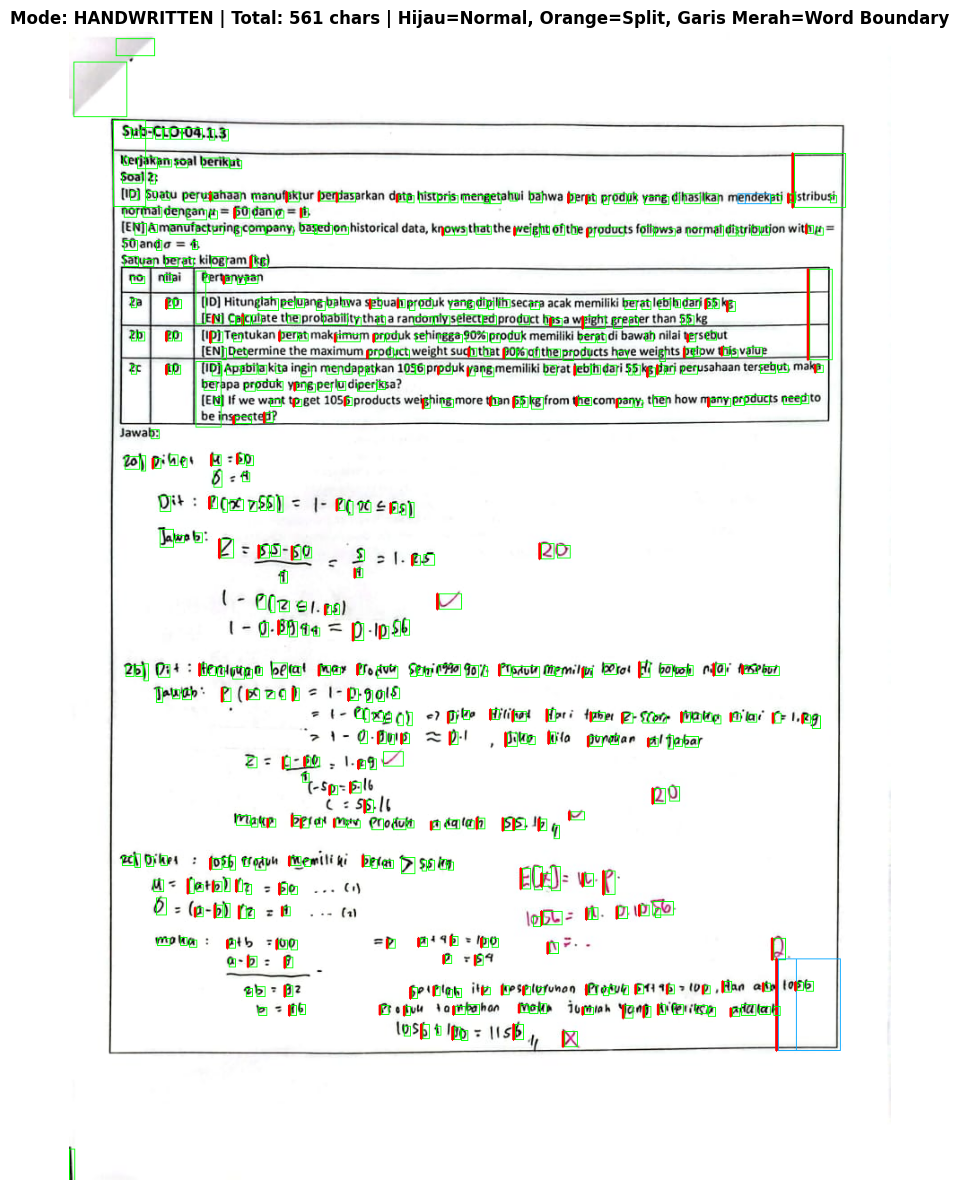


📊 STATISTIK SEGMENTASI LENGKAP
  Mode deteksi       : HANDWRITTEN
  Total karakter     : 561
  Karakter di-split  : 4 (0.7%)
  Jumlah baris       : 41
  Awal kata terdeteksi: 178

  Detail per baris:
    └─ Baris  1:    1 karakter
    └─ Baris  2:    1 karakter
    └─ Baris  3:   10 karakter
    └─ Baris  4:    7 karakter
    └─ Baris  5:    7 karakter
    └─ Baris  6:   38 karakter
    └─ Baris  7:   34 karakter
    └─ Baris  8:   11 karakter
    └─ Baris  9:    4 karakter
    └─ Baris 10:   43 karakter
    └─ Baris 11:   26 karakter
    └─ Baris 12:   38 karakter
    └─ Baris 13:   23 karakter
    └─ Baris 14:   20 karakter
    └─ Baris 15:    2 karakter
    └─ Baris 16:    9 karakter
    └─ Baris 17:    1 karakter
    └─ Baris 18:   14 karakter
    └─ Baris 19:   10 karakter
    └─ Baris 20:    3 karakter
    └─ Baris 21:    2 karakter
    └─ Baris 22:    7 karakter
    └─ Baris 23:    9 karakter
    └─ Baris 24:   35 karakter
    └─ Baris 25:   12 karakter
    └─ Baris 26:   25 ka

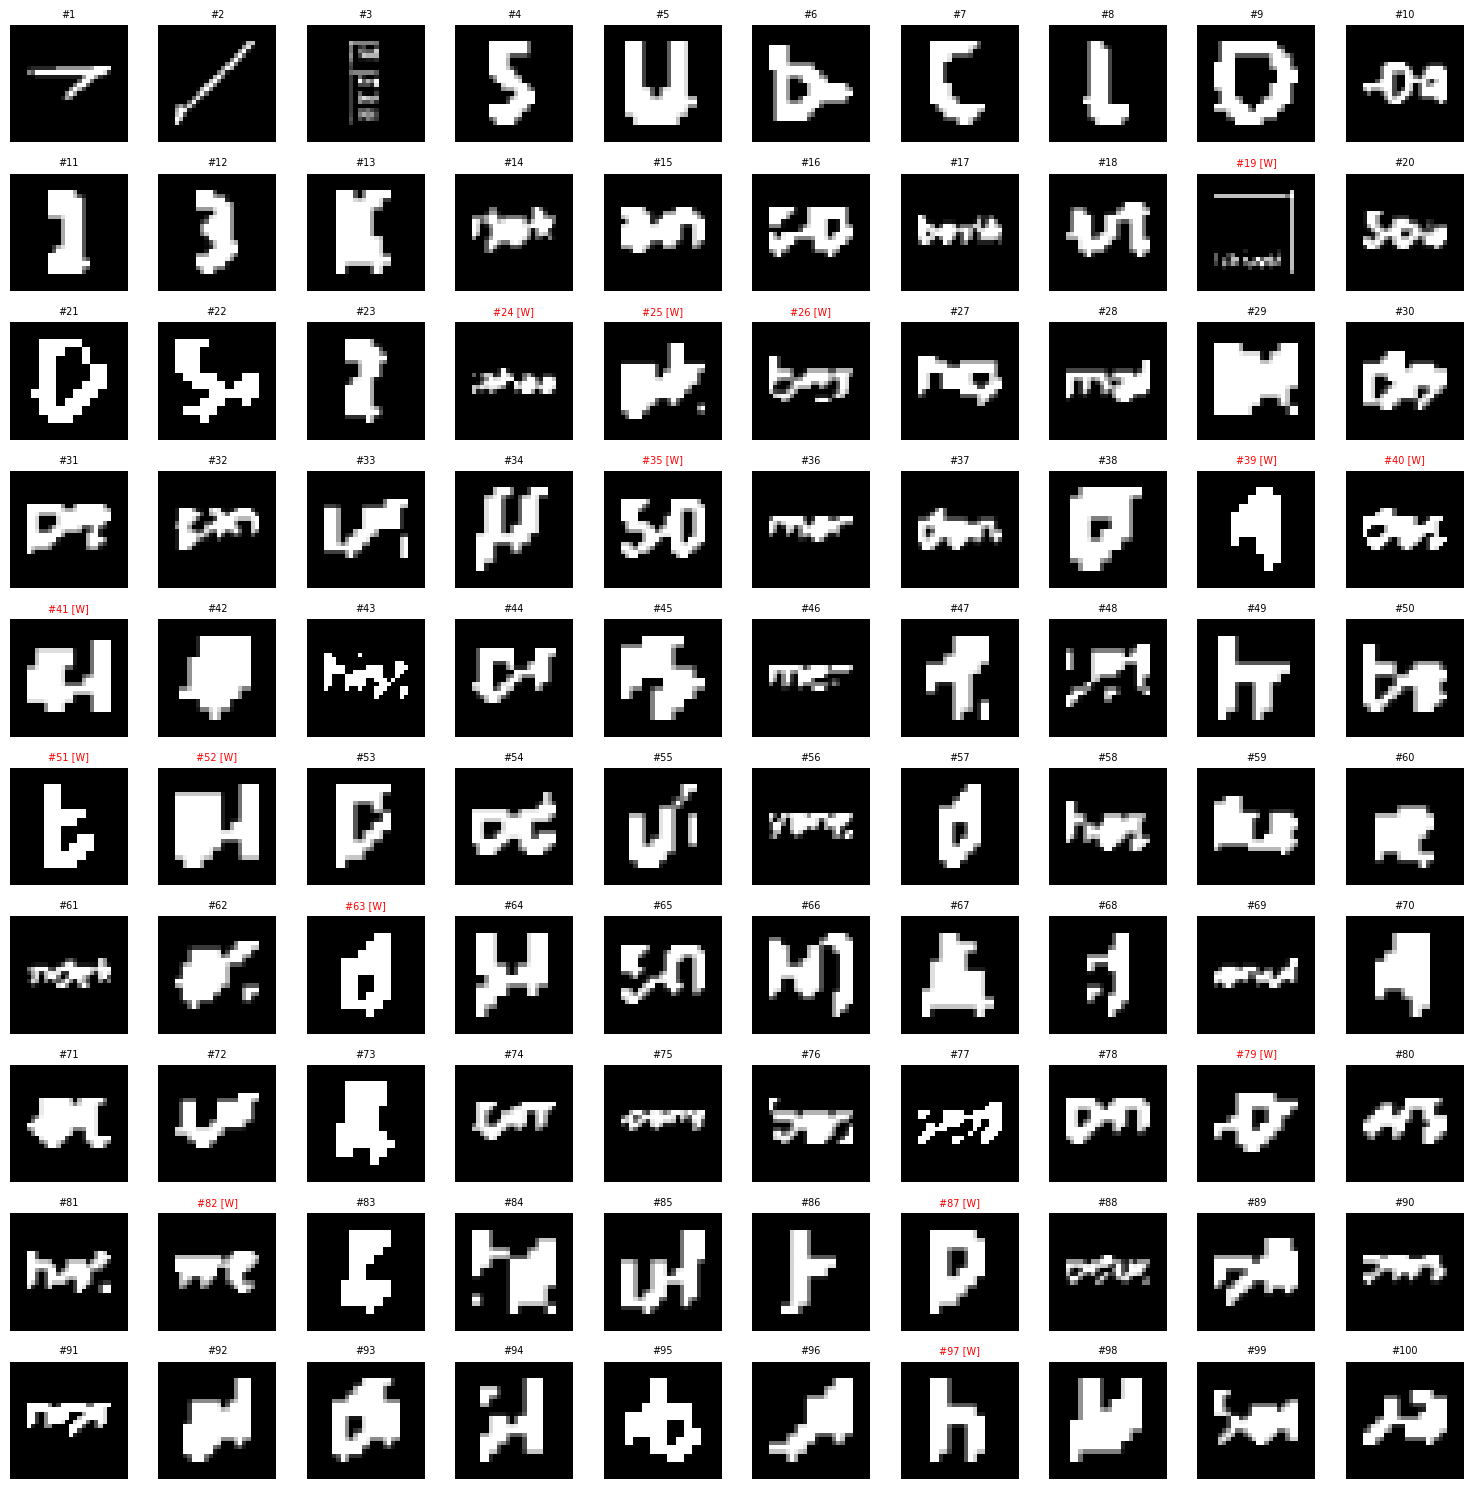


📦 Batch 2/6
📊 Menampilkan karakter #101 - #200 (dari 561 total)


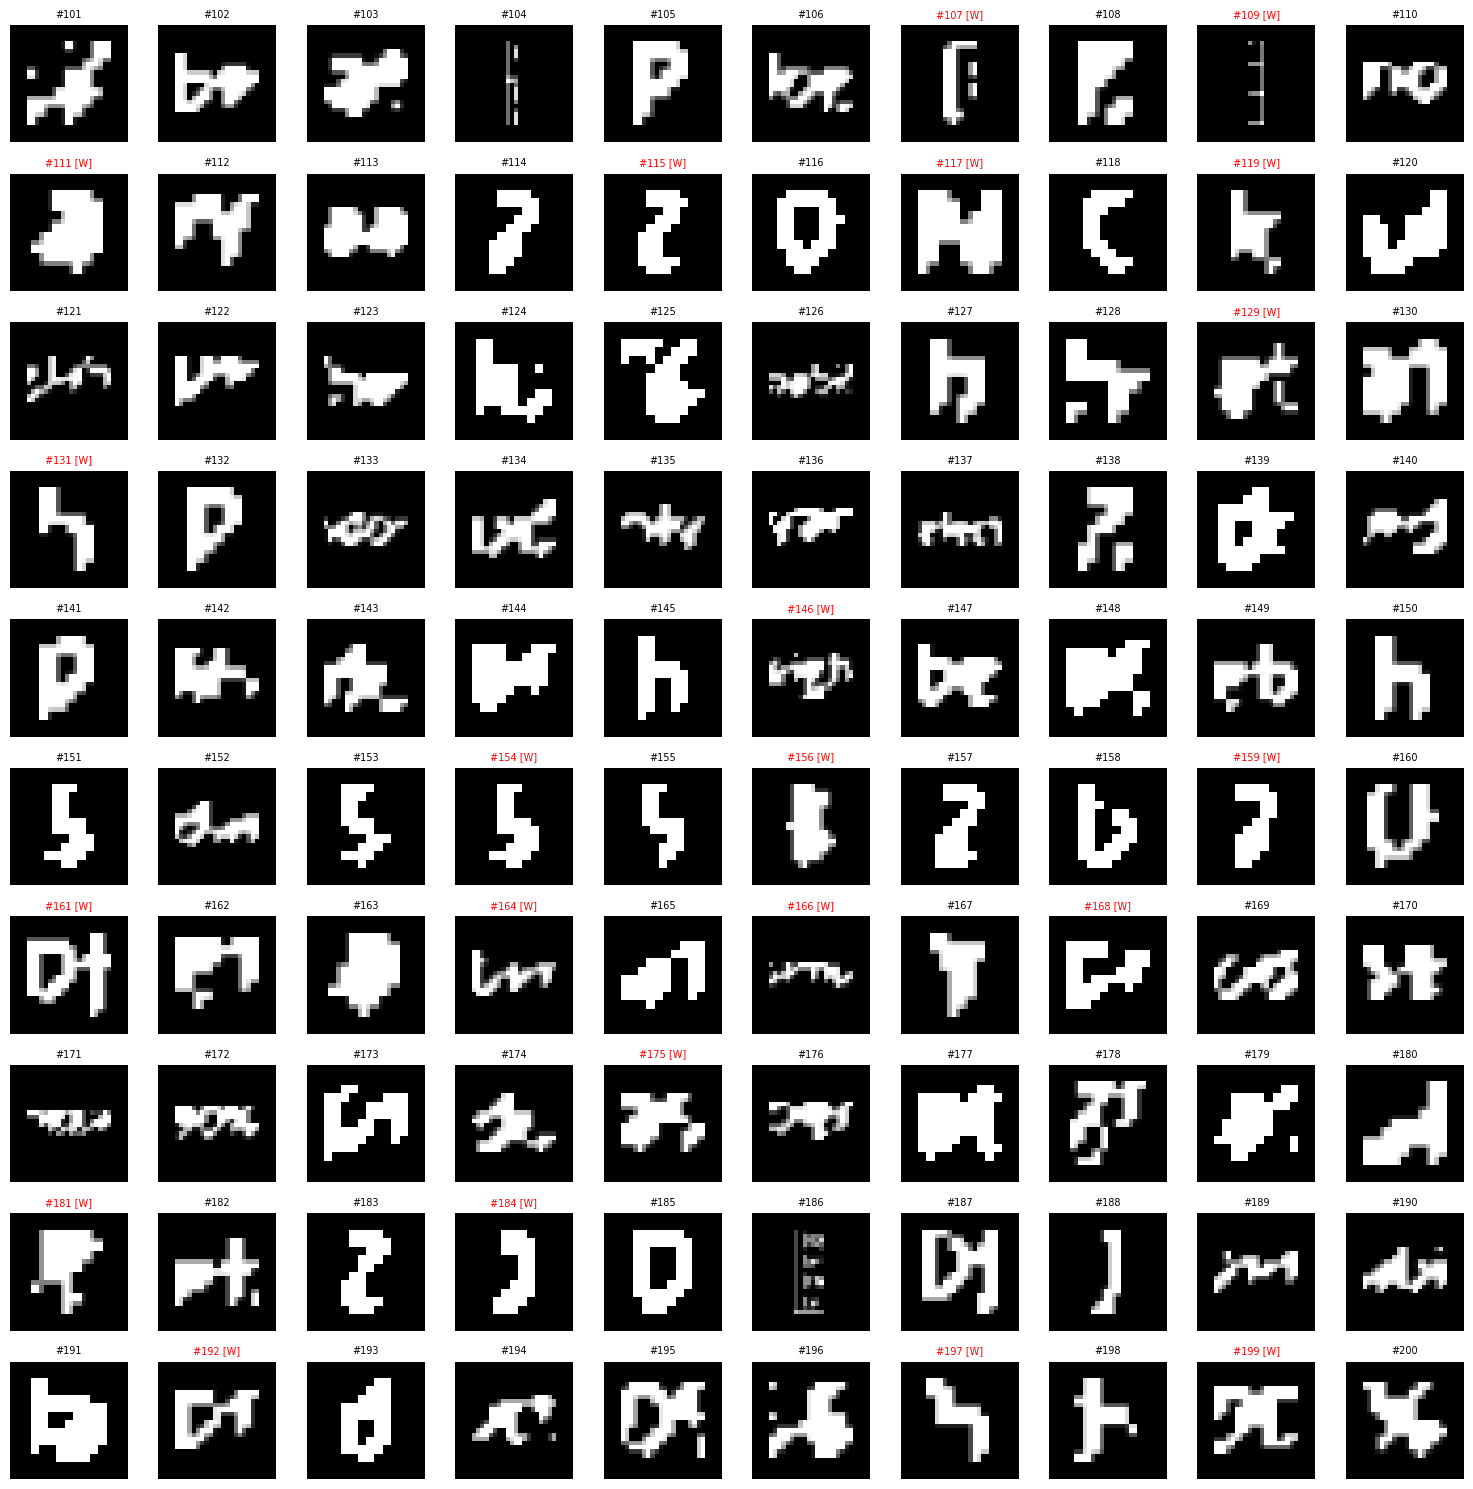


📦 Batch 3/6
📊 Menampilkan karakter #201 - #300 (dari 561 total)


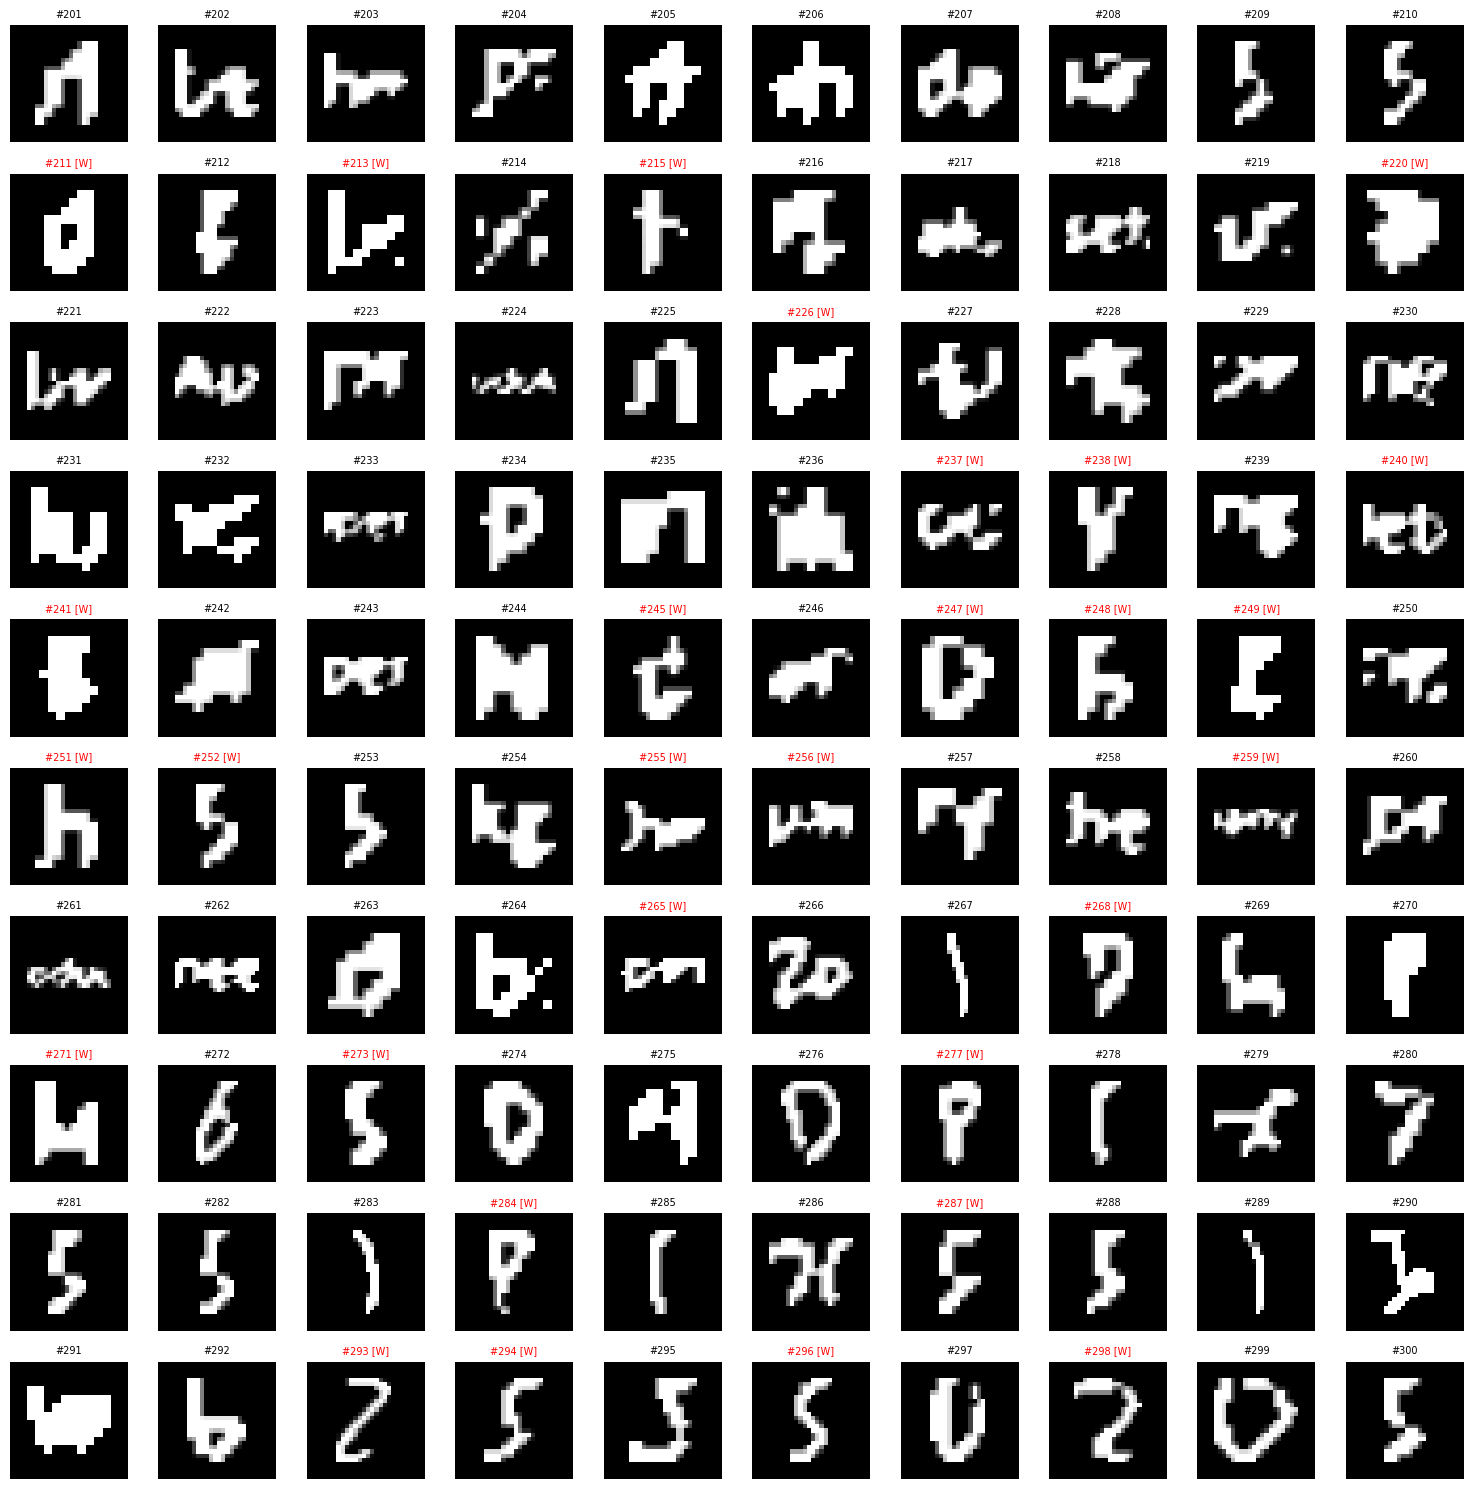


📦 Batch 4/6
📊 Menampilkan karakter #301 - #400 (dari 561 total)


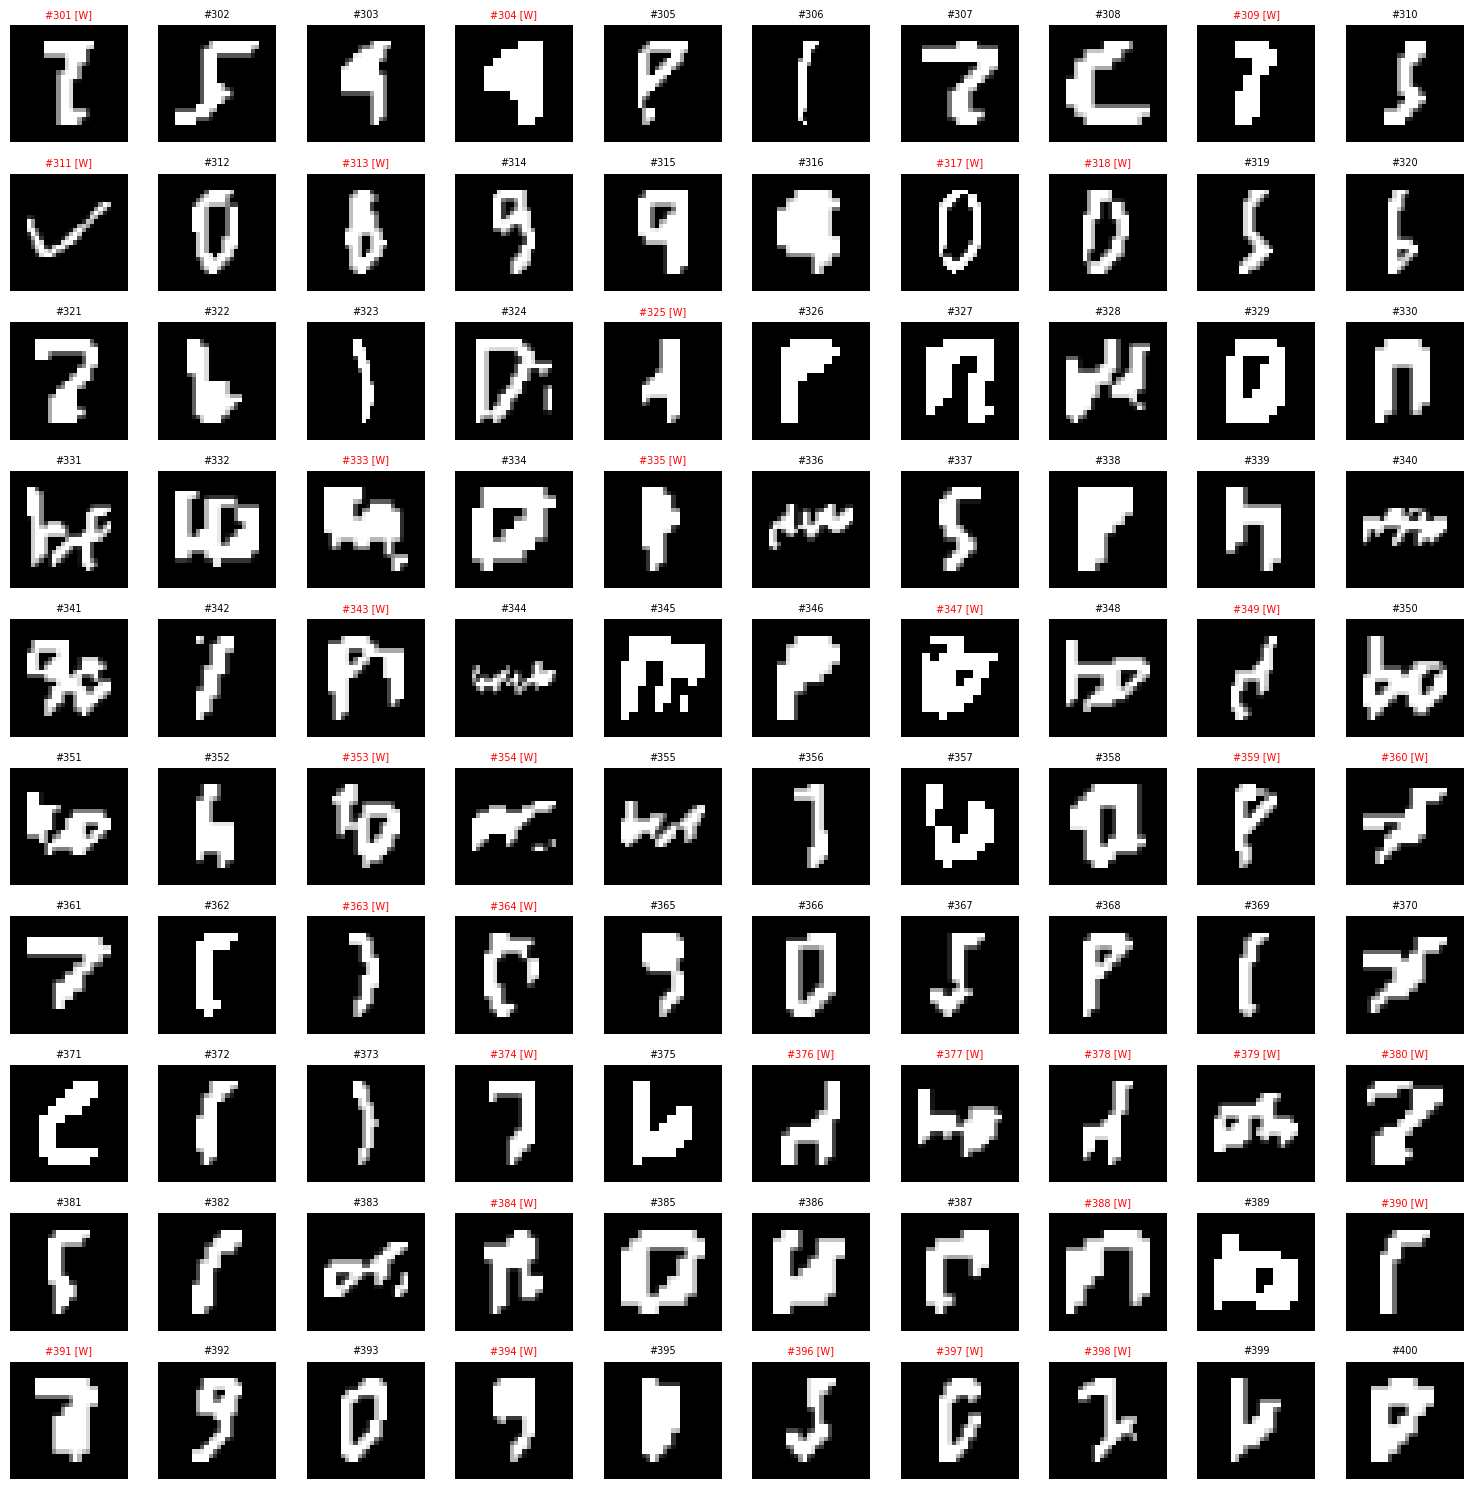


📦 Batch 5/6
📊 Menampilkan karakter #401 - #500 (dari 561 total)


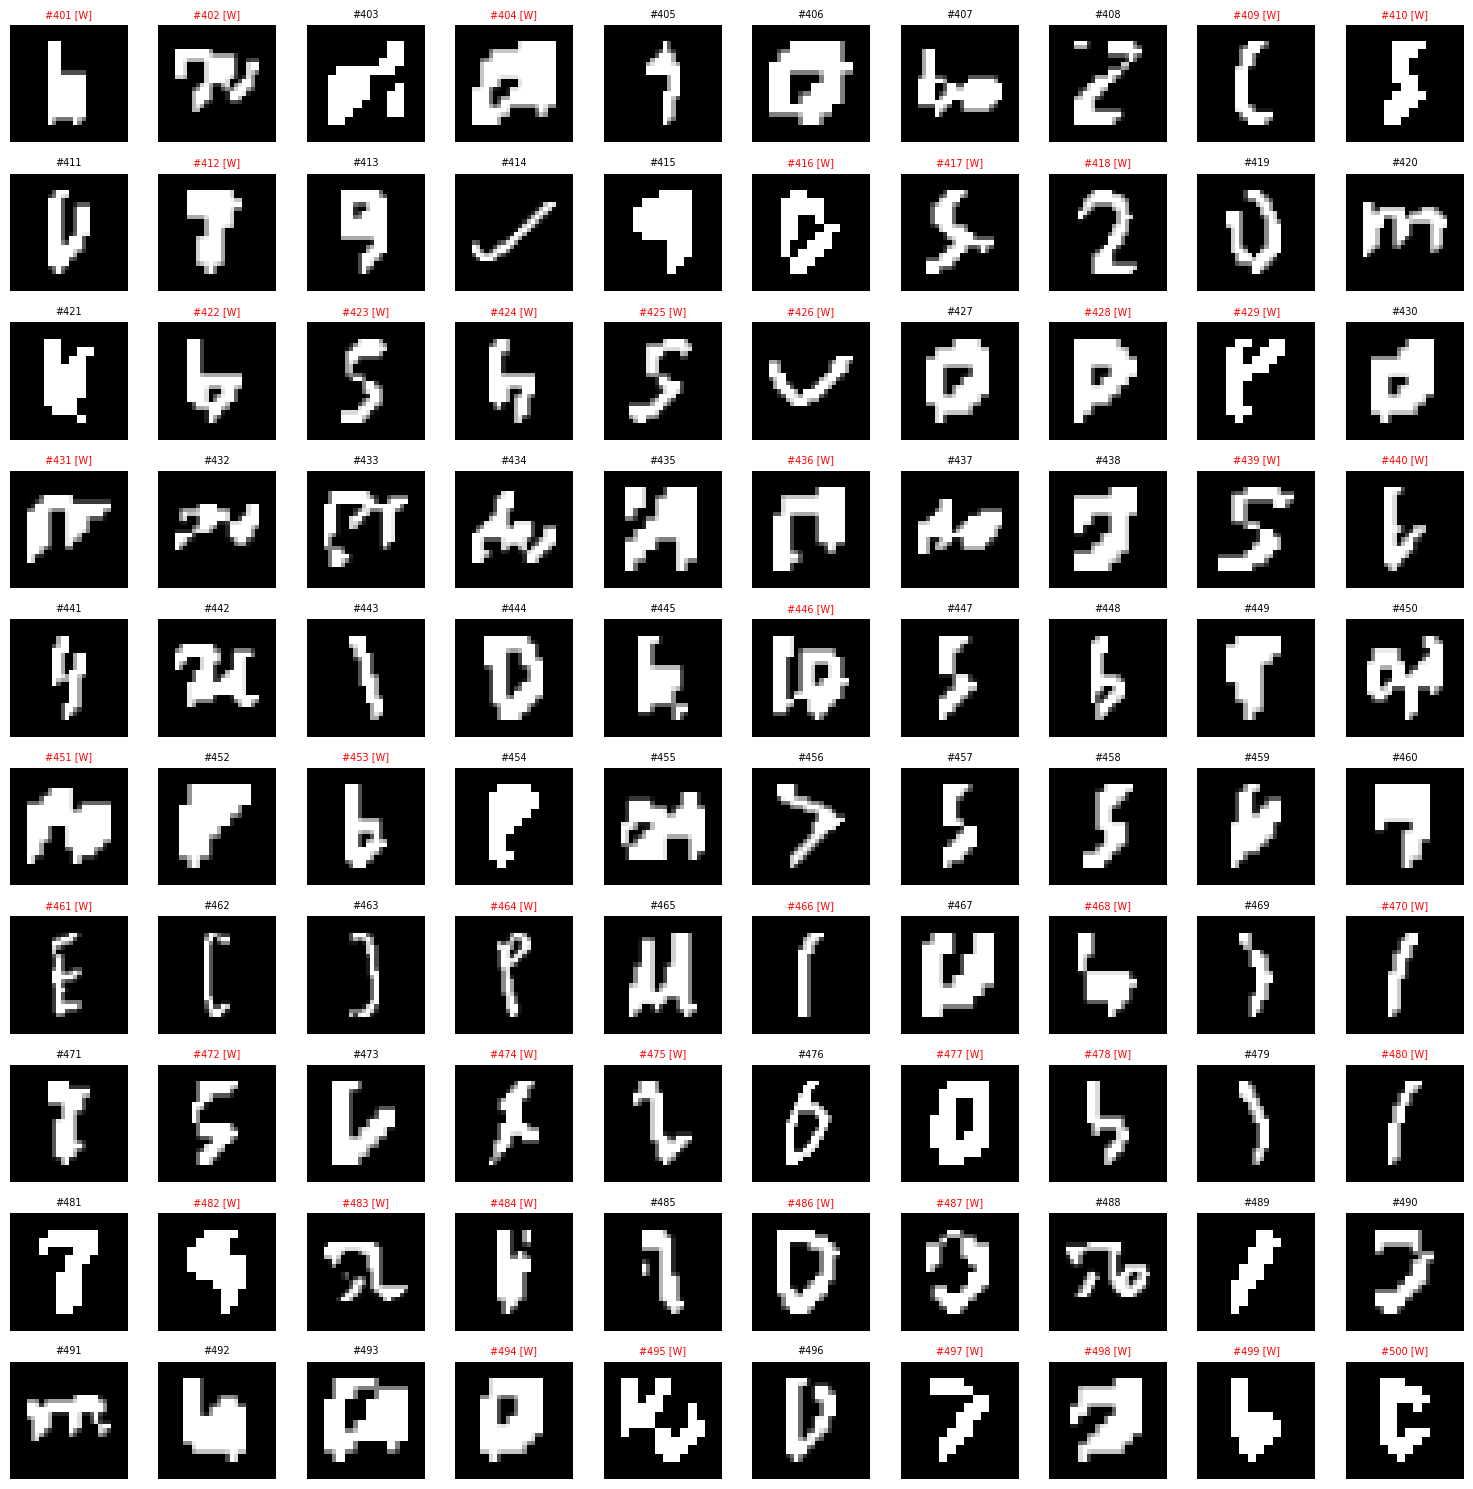


📦 Batch 6/6
📊 Menampilkan karakter #501 - #561 (dari 561 total)


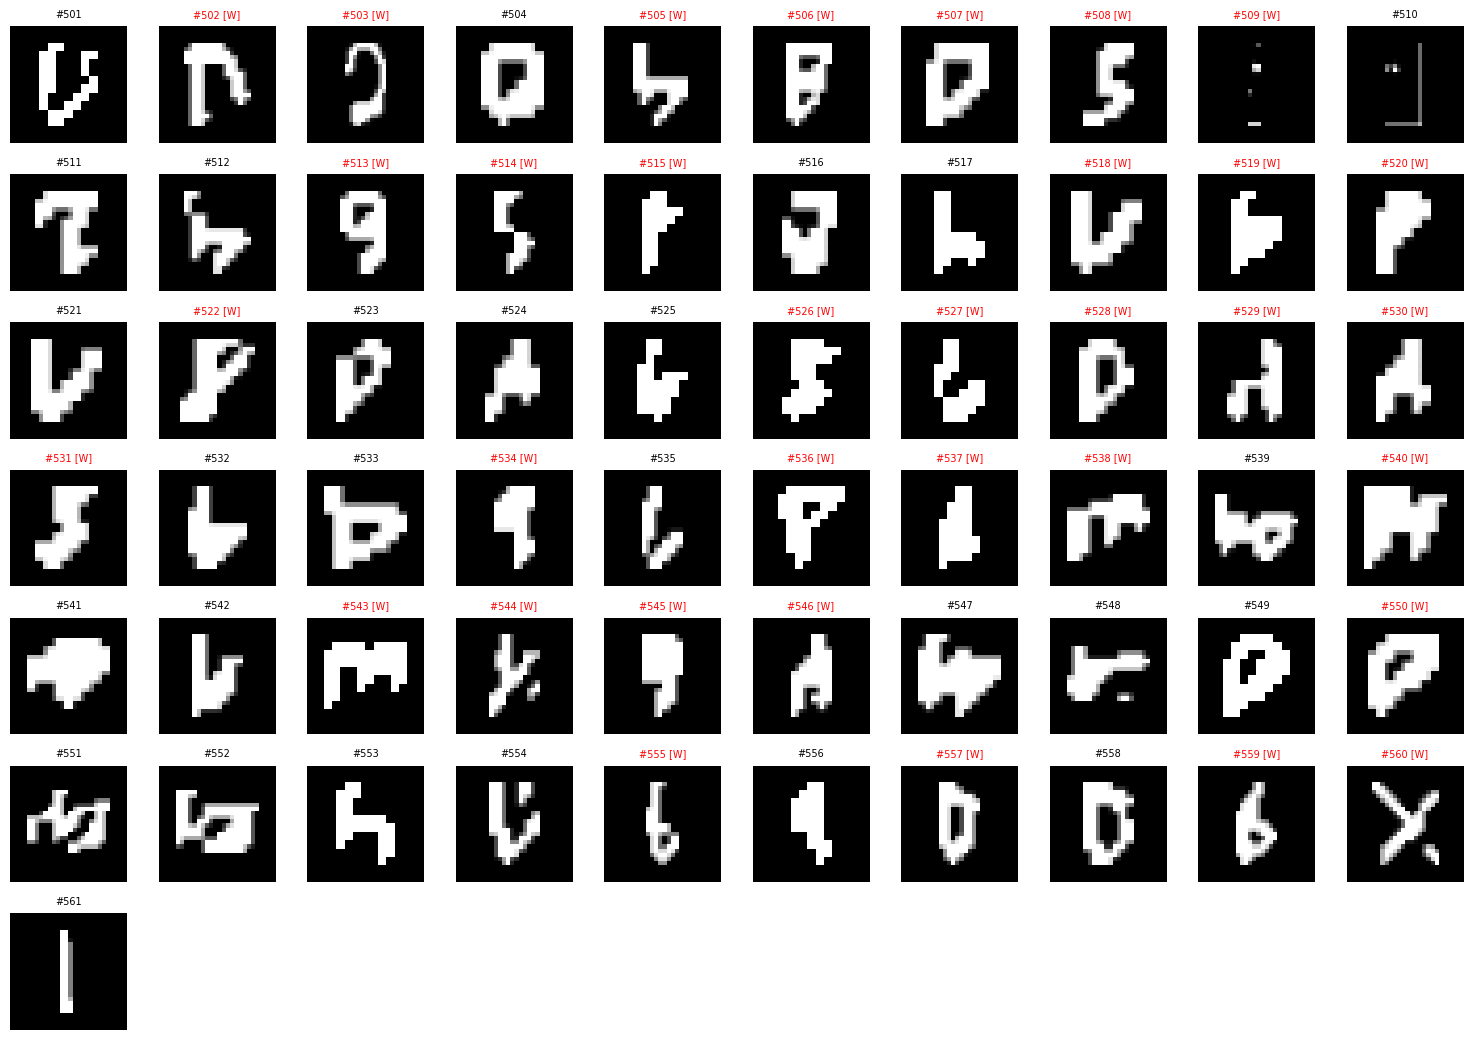


💾 Mau export dataset untuk training CNN? (y/n)

📝 DEMO REKONSTRUKSI TEKS
Setelah kamu train CNN dan punya predictions, panggil:
  predictions = model.predict(segmenter.characters)
  text = segmenter.reconstruct_text(predictions)


In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
import os
import json

class HandwritingSegmenter:
    def __init__(self, debug=False):
        self.debug = debug
        self.original_img = None
        self.processed_img = None
        self.mode = None
        self.characters = []
        self.char_info = []
        
    def detect_mode(self, gray):
        """Deteksi apakah gambar tulisan tangan atau digital/printed"""
        variance = cv2.Laplacian(gray, cv2.CV_64F).var()
        edges = cv2.Canny(gray, 50, 150)
        edge_density = np.sum(edges > 0) / (gray.shape[0] * gray.shape[1])
        mean_val = np.mean(gray)
        std_val = np.std(gray)
        
        if variance < 100 and mean_val > 200 and std_val < 50:
            return 'digital'
        else:
            return 'handwritten'
    
    def preprocess_handwritten(self, gray):
        """Preprocessing untuk tulisan tangan"""
        denoised = cv2.bilateralFilter(gray, 9, 75, 75)
        thresh = cv2.adaptiveThreshold(
            denoised, 255,
            cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
            cv2.THRESH_BINARY_INV,
            blockSize=11, C=2
        )
        kernel_open = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))
        opened = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel_open)
        kernel_close = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))
        closed = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, kernel_close)
        return closed
    
    def preprocess_digital(self, img):
        """Preprocessing untuk teks digital"""
        if len(img.shape) == 3:
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        else:
            gray = img
        
        _, thresh = cv2.threshold(gray, 0, 255, 
                                  cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
        kernel = np.ones((2, 2), np.uint8)
        cleaned = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)
        kernel_dilate = np.ones((2, 2), np.uint8)
        dilated = cv2.dilate(cleaned, kernel_dilate, iterations=1)
        return dilated
    
    def remove_lines(self, thresh):
        """Hapus garis horizontal/vertikal"""
        img_h, img_w = thresh.shape
        horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (int(img_w/20), 1))
        horizontal_lines = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, horizontal_kernel, iterations=2)
        vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, int(img_h/20)))
        vertical_lines = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, vertical_kernel, iterations=2)
        lines = cv2.add(horizontal_lines, vertical_lines)
        cleaned = cv2.subtract(thresh, lines)
        return cleaned
    
    def group_into_lines(self, bboxes, y_tolerance=15):
        """Kelompokkan bounding box berdasarkan baris dengan metadata lengkap"""
        if not bboxes:
            return []
        
        sorted_boxes = sorted(bboxes, key=lambda b: b[1])
        lines = []
        current_line = [sorted_boxes[0]]
        current_y = sorted_boxes[0][1]
        
        for box in sorted_boxes[1:]:
            x, y, w, h = box
            if abs(y - current_y) <= y_tolerance:
                current_line.append(box)
            else:
                current_line.sort(key=lambda b: b[0])
                lines.append(current_line)
                current_line = [box]
                current_y = y
        
        if current_line:
            current_line.sort(key=lambda b: b[0])
            lines.append(current_line)
        
        return lines
    
    def is_valid_char(self, x, y, w, h, img_w, img_h, mode='handwritten'):
        """Filter karakter valid"""
        if mode == 'digital':
            if w < 3 or h < 6:
                return False
            if w * h < 30:
                return False
            aspect = w / float(h)
            if aspect > 5 or aspect < 0.08:
                return False
            if w > img_w * 0.9 or h > img_h * 0.3:
                return False
            if w > 200 or h > 100:
                return False
        else:
            if w < 5 or h < 8:
                return False
            if w * h < 50:
                return False
            aspect = w / float(h)
            if aspect > 4 or aspect < 0.1:
                return False
            if w > img_w * 0.7 or h > img_h * 0.5:
                return False
            if w > 150 or h > 150:
                return False
        return True
    
    def split_connected_chars(self, roi, bbox, mode='handwritten'):
        """Pisahkan huruf yang nyambung"""
        x, y, w, h = bbox
        vertical_proj = np.sum(roi, axis=0)
        vertical_proj = vertical_proj / float(h) if h > 0 else vertical_proj
        
        if mode == 'digital':
            threshold = np.mean(vertical_proj) * 0.2
            min_width = 20
        else:
            threshold = np.mean(vertical_proj) * 0.3
            min_width = 35
        
        valleys = []
        in_valley = False
        valley_start = 0
        
        for i, val in enumerate(vertical_proj):
            if val < threshold and not in_valley:
                in_valley = True
                valley_start = i
            elif val >= threshold and in_valley:
                valley_mid = (valley_start + i) // 2
                valleys.append(valley_mid)
                in_valley = False
        
        good_valleys = [v for v in valleys if 0.2*w < v < 0.8*w]
        
        if good_valleys and w > min_width:
            split_point = good_valleys[0]
            return [
                (roi[:, :split_point], (x, y, split_point, h)),
                (roi[:, split_point:], (x+split_point, y, w-split_point, h))
            ]
        return [(roi, bbox)]
    
    def extract_char(self, roi):
        """Normalize ROI ke 28x28"""
        h, w = roi.shape
        target_size = 28
        padding = 4
        max_dim = target_size - 2 * padding
        
        if w > h:
            scale = max_dim / float(w)
            new_w = max_dim
            new_h = max(1, int(h * scale))
        else:
            scale = max_dim / float(h)
            new_w = max(1, int(w * scale))
            new_h = max_dim
        
        try:
            resized = cv2.resize(roi, (new_w, new_h), interpolation=cv2.INTER_AREA)
        except:
            return None
        
        canvas = np.zeros((target_size, target_size), dtype=np.uint8)
        start_x = (target_size - new_w) // 2
        start_y = (target_size - new_h) // 2
        canvas[start_y:start_y+new_h, start_x:start_x+new_w] = resized
        return canvas
    
    def detect_word_boundaries(self, line_boxes):
        """Deteksi spasi antar kata dalam satu baris"""
        if len(line_boxes) < 2:
            return []
        
        gaps = []
        for i in range(len(line_boxes) - 1):
            x1, y1, w1, h1 = line_boxes[i]
            x2, y2, w2, h2 = line_boxes[i + 1]
            
            gap = x2 - (x1 + w1)
            avg_width = (w1 + w2) / 2
            gaps.append((i, gap, avg_width))
        
        # Spasi dianggap valid jika gap > 1.5x rata-rata lebar karakter
        word_boundaries = []
        for i, gap, avg_width in gaps:
            if gap > avg_width * 1.5:
                word_boundaries.append(i + 1)  # Index setelah spasi
        
        return word_boundaries
    
    def process(self, image_path):
        """Main processing pipeline - TANPA BATASAN JUMLAH"""
        img = cv2.imread(image_path)
        if img is None:
            print(f"❌ Error: Tidak dapat membaca '{image_path}'")
            return None, [], []
        
        self.original_img = img.copy()
        img_h, img_w = img.shape[:2]
        
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        self.mode = self.detect_mode(gray)
        print(f"🔍 Mode: {self.mode.upper()}")
        
        print("⚙️  Preprocessing...")
        if self.mode == 'digital':
            thresh = self.preprocess_digital(img)
        else:
            thresh = self.preprocess_handwritten(gray)
        
        print("🧹 Cleaning...")
        cleaned = self.remove_lines(thresh)
        
        print("🔎 Detecting contours...")
        contours, _ = cv2.findContours(cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        all_bboxes = []
        for c in contours:
            x, y, w, h = cv2.boundingRect(c)
            if self.is_valid_char(x, y, w, h, img_w, img_h, self.mode):
                all_bboxes.append((x, y, w, h))
        
        print(f"📦 Kandidat: {len(all_bboxes)}")
        
        y_tol = 10 if self.mode == 'digital' else 20
        lines = self.group_into_lines(all_bboxes, y_tolerance=y_tol)
        print(f"📄 Baris: {len(lines)}")
        
        # Process SEMUA karakter
        self.characters = []
        self.char_info = []
        visualization = self.original_img.copy()
        
        char_counter = 0
        
        for line_idx, line_boxes in enumerate(lines):
            # Deteksi word boundaries
            word_boundaries = self.detect_word_boundaries(line_boxes)
            
            char_in_line = 0
            for char_idx, bbox in enumerate(line_boxes):
                x, y, w, h = bbox
                roi = cleaned[y:y+h, x:x+w]
                
                splits = self.split_connected_chars(roi, bbox, self.mode)
                
                for sub_roi, (sx, sy, sw, sh) in splits:
                    char_img = self.extract_char(sub_roi)
                    
                    if char_img is not None:
                        # Cek apakah ini awal kata baru
                        is_word_start = char_in_line in word_boundaries
                        
                        self.characters.append(char_img)
                        self.char_info.append({
                            'id': char_counter,
                            'line': line_idx,
                            'char_in_line': char_in_line,
                            'bbox': (sx, sy, sw, sh),
                            'is_word_start': is_word_start,
                            'split': len(splits) > 1
                        })
                        
                        color = (0, 255, 0) if len(splits) == 1 else (255, 165, 0)
                        cv2.rectangle(visualization, (sx, sy), (sx+sw, sy+sh), color, 1)
                        
                        # Tanda word boundary (garis merah vertikal)
                        if is_word_start:
                            cv2.line(visualization, (sx-2, sy), (sx-2, sy+sh), (0, 0, 255), 2)
                        
                        char_counter += 1
                        char_in_line += 1
        
        self.processed_img = visualization
        print(f"✅ Total karakter: {len(self.characters)}")
        
        return visualization, self.characters, self.char_info
    
    def reconstruct_text(self, predictions):
        """
        Rekonstruksi teks dari hasil prediksi CNN
        predictions: list of predicted labels (harus sama panjang dengan self.characters)
        """
        if len(predictions) != len(self.char_info):
            print(f"⚠️  Warning: {len(predictions)} prediksi vs {len(self.char_info)} karakter")
            return ""
        
        lines_text = defaultdict(list)
        
        for pred, info in zip(predictions, self.char_info):
            line_num = info['line']
            
            # Tambahkan spasi jika ini awal kata baru
            if info['is_word_start'] and lines_text[line_num]:
                lines_text[line_num].append(' ')
            
            lines_text[line_num].append(pred)
        
        # Gabungkan semua baris
        full_text = '\n'.join([''.join(lines_text[i]) for i in sorted(lines_text.keys())])
        return full_text
    
    def export_dataset(self, output_dir='segmented_chars', save_images=True):
        """Export semua karakter untuk training CNN"""
        os.makedirs(output_dir, exist_ok=True)
        
        # Save metadata
        metadata = {
            'total_chars': len(self.characters),
            'total_lines': len(set([info['line'] for info in self.char_info])),
            'mode': self.mode,
            'characters': self.char_info
        }
        
        with open(os.path.join(output_dir, 'metadata.json'), 'w') as f:
            json.dump(metadata, f, indent=2)
        
        # Save images
        if save_images:
            img_dir = os.path.join(output_dir, 'images')
            os.makedirs(img_dir, exist_ok=True)
            
            for i, (char_img, info) in enumerate(zip(self.characters, self.char_info)):
                filename = f"char_{info['id']:04d}_line{info['line']:02d}.png"
                cv2.imwrite(os.path.join(img_dir, filename), char_img)
        
        print(f"💾 Dataset disimpan di: {output_dir}/")
        print(f"   - {len(self.characters)} gambar karakter")
        print(f"   - metadata.json")
        
        return output_dir
    
    def visualize(self, start_idx=0, count=50):
        """Visualize karakter mulai dari index tertentu"""
        if not self.characters:
            print("⚠️  Tidak ada karakter")
            return
        
        total = len(self.characters)
        end_idx = min(start_idx + count, total)
        chars_to_show = self.characters[start_idx:end_idx]
        
        print(f"📊 Menampilkan karakter #{start_idx+1} - #{end_idx} (dari {total} total)")
        
        n = len(chars_to_show)
        cols = 10
        rows = (n + cols - 1) // cols
        
        fig, axes = plt.subplots(rows, cols, figsize=(15, rows*1.5))
        if rows == 1:
            axes = axes.reshape(1, -1)
        axes = axes.flatten()
        
        for i in range(len(axes)):
            if i < n:
                actual_idx = start_idx + i
                info = self.char_info[actual_idx]
                axes[i].imshow(chars_to_show[i], cmap='gray')
                
                title = f"#{actual_idx+1}"
                if info['is_word_start']:
                    title += " [W]"  # Word start
                
                axes[i].set_title(title, fontsize=7, color='red' if info['is_word_start'] else 'black')
            axes[i].axis('off')
        
        plt.tight_layout()
        plt.show()
    
    def show_statistics(self):
        """Tampilkan statistik lengkap"""
        if not self.char_info:
            print("Belum ada data")
            return
        
        total_chars = len(self.characters)
        total_lines = len(set([info['line'] for info in self.char_info]))
        split_chars = sum([1 for info in self.char_info if info['split']])
        word_starts = sum([1 for info in self.char_info if info['is_word_start']])
        
        print("\n" + "="*70)
        print("📊 STATISTIK SEGMENTASI LENGKAP")
        print("="*70)
        print(f"  Mode deteksi       : {self.mode.upper()}")
        print(f"  Total karakter     : {total_chars}")
        print(f"  Karakter di-split  : {split_chars} ({split_chars/total_chars*100:.1f}%)")
        print(f"  Jumlah baris       : {total_lines}")
        print(f"  Awal kata terdeteksi: {word_starts}")
        print(f"\n  Detail per baris:")
        
        line_counts = Counter([info['line'] for info in self.char_info])
        for line_num in sorted(line_counts.keys()):
            print(f"    └─ Baris {line_num+1:2d}: {line_counts[line_num]:4d} karakter")
        print("="*70)


# ==================== EKSEKUSI ====================
if __name__ == "__main__":
    segmenter = HandwritingSegmenter(debug=True)
    
    image_file = 'test(1).jpeg'  # GANTI DENGAN FILE KAMU
    
    print("="*70)
    print("🚀 SMART SEGMENTATION v3.0 - UNLIMITED CHARACTERS")
    print("="*70)
    print()
    
    # Proses gambar
    result_img, characters, info = segmenter.process(image_file)
    
    if result_img is not None:
        # Show full result
        plt.figure(figsize=(18, 12))
        plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
        mode_label = "DIGITAL" if segmenter.mode == 'digital' else "HANDWRITTEN"
        plt.title(
            f"Mode: {mode_label} | Total: {len(characters)} chars | "
            f"Hijau=Normal, Orange=Split, Garis Merah=Word Boundary", 
            fontsize=12, fontweight='bold'
        )
        plt.axis('off')
        plt.tight_layout()
        plt.show()
        
        # Show statistics
        segmenter.show_statistics()
        
        # Preview karakter dalam batch
        print("\n" + "="*70)
        print("🔍 PREVIEW KARAKTER (BATCH MODE)")
        print("="*70)
        
        total_chars = len(characters)
        batch_size = 100  # Ubah sesuai kebutuhan (50, 100, 200, dst)
        
        # Tanya user mau lihat berapa batch
        max_batches = (total_chars + batch_size - 1) // batch_size
        print(f"Total {total_chars} karakter, terbagi dalam {max_batches} batch (@{batch_size} char)")
        print(f"Menampilkan 3 batch pertama...")
        print()
        
        # Tanya user mau lihat berapa batch
        print(f"\n❓ Mau tampilkan berapa batch? (max: {max_batches})")
        print(f"   Ketik angka (misal: 5) atau 'all' untuk semua, atau Enter untuk 3 batch saja")
        
        # UBAH INI UNTUK TAMPILKAN SEMUA BATCH OTOMATIS:
        num_batches_to_show = max_batches  # Tampilkan SEMUA batch
        # num_batches_to_show = min(3, max_batches)  # Atau batasi jadi 3 batch
        
        # Kalau mau interaktif, uncomment ini dan comment baris di atas:
        # user_input = input("   > ").strip().lower()
        # if user_input == 'all':
        #     num_batches_to_show = max_batches
        # elif user_input.isdigit():
        #     num_batches_to_show = min(int(user_input), max_batches)
        # else:
        #     num_batches_to_show = min(3, max_batches)
        
        print(f"\n🎨 Menampilkan {num_batches_to_show} batch...")
        
        # Tampilkan batch
        for batch_num in range(num_batches_to_show):
            start_idx = batch_num * batch_size
            print(f"\n📦 Batch {batch_num + 1}/{max_batches}")
            segmenter.visualize(start_idx=start_idx, count=batch_size)
        
        # Info untuk batch selanjutnya
        if num_batches_to_show < max_batches:
            print(f"\n💡 Untuk melihat batch lainnya, gunakan:")
            for i in range(num_batches_to_show, min(num_batches_to_show + 3, max_batches)):
                print(f"   segmenter.visualize(start_idx={i*batch_size}, count={batch_size})  # Batch {i+1}")
            if max_batches > num_batches_to_show + 3:
                print("   dst...")
        
        # Export dataset untuk training
        print("\n💾 Mau export dataset untuk training CNN? (y/n)")
        # segmenter.export_dataset('output_dataset')
        
        # DEMO: Rekonstruksi teks (setelah punya model CNN)
        print("\n" + "="*70)
        print("📝 DEMO REKONSTRUKSI TEKS")
        print("="*70)
        print("Setelah kamu train CNN dan punya predictions, panggil:")
        print("  predictions = model.predict(segmenter.characters)")
        print("  text = segmenter.reconstruct_text(predictions)")
        print("="*70)